# Convolutional Neural Networks

In [18]:
import numpy as np
import pandas as pd 
import sys, os
import matplotlib.pyplot as plt

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.plotting import plot_triangle
from sklearn.model_selection import train_test_split

Convolution literally means applying a filter to the data to extract *different* information. This allows you to keep your shape like 2D or 3D. Imagine an image data of 256x256, for a dense (fully connected) deep neural network, you first flatten this and then you connect the inputs and outputs of every neuron with every other neuron in the next layer. <br>

Convolution allows you to keep the shape 2D, and you can place a convolution kernel e.g. like a gaussian smoothing window 5x5 matrix and glide it over the data. As a result you might be able to get a more useful information e.g. like the edges of shapes. You also do not have to connect all neurons with each other. They can be partially connected. 

There are some other concepts like Pooling (down-sampling the data), Flattening and Dense Layers. Let's go over an example.

In [19]:
df_angle = generate_triangle_data(n_samples=10_000, angle_mode="random")
X_train, X_test, y_train, y_test = train_test_split(df_angle[["a", "b", "angle_deg"]], 
                                                    df_angle["c"],test_size=0.2, random_state=42)

(np.float64(0.0), np.float64(200.0), np.float64(0.0), np.float64(100.0))

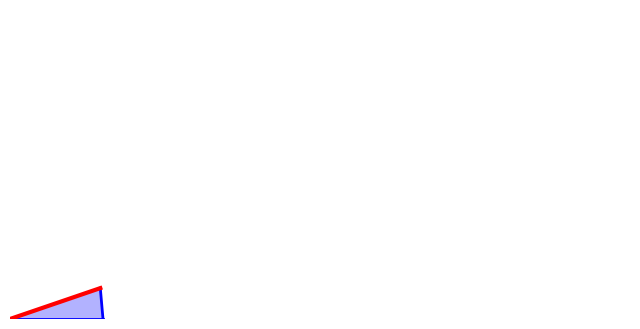

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_triangle(30,10,85, annotation=False, ax=ax)
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.axis("off")

In order to use CNN, we need another package like the keras from tensorflow. The CNN works best with the image data. So let's make our lives more complicated by first creating random triangle images and labeling them with their longest side. Then we train a model.

In [21]:
from hypotai.models.convolutional import triangle_image_array, get_model

In [22]:
X = []
y = []
np.random.seed(42)

if os.path.exists("../hypotai/data/triangle_data.npz"):
    data = np.load("../hypotai/data/triangle_data.npz")
    X = data["X"]
    y = data["y"]
else:
    # generate triangle images and labels (can take a while)
    df = generate_triangle_data(n_samples=5000, angle_mode="random")
    for i in range(5000):
        a, b, angle = df.iloc[i][["a", "b", "angle_deg"]]
        img = triangle_image_array(a, b, angle)
        # label
        c = df.iloc[i]["c"]
        
        X.append(img)
        y.append(c)

    X = np.array(X)[..., np.newaxis]  # Shape (5000, 64, 64, 1)
    y = np.array(y)

    np.savez_compressed("../hypotai/data/triangle_data.npz", X=X, y=y)

Now I defined a CNN model inside the models.convolutional to avoid crowding in here. Let's load the first model and look at it.

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

test_model1 = get_model(model_number=1)
test_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,163,141 (4.44 MB)

 Trainable params: 387,713 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 775,428 (2.96 MB)

Consider the first layer `Conv2d` this has 32 kernels (filters) each with 3x3 matrices as weights. In this layer, each of these 32 kernels slide through your image (by placing this 3x3 matrix on the corner and calculating new values) then also for each there is a bias value. The default padding is placing the left corner of the filter on the left corner of the image. Then you multiply all these 9 numbers and sum the results, add a bias term and apply activation. The final number is what you put in the central cell. 

You then slide one pixel and do the same thing. At the end you end up with a `(None, 62, 62, 32)` shape because 1 pixel at the top,bottom,left, and right are lost, and you have this 62x62 for each of the 32 kernels.

To reduce the dimension, you apply a max pooling. Which takes these now 62x62 images and places a 2x2 kernel and only takes the maximum value in each. Effectively smoothing and reducing the size to half.

The next layer is again a convolutional 2D layer, again a 3x3 filter but this time there 64 of them. You lose the pixels at the edges again, so the image now becomes 29x29 but you have more kernels. 

makes sense? <br>

What about those number of parameters? Let's look at the first layer again. You have 3x3 kernels (weights) and 1 bias term. The image is in gray-scale so it is one dimensional `3x3x1 + 1 = 10` parameters per kernel. Since you have 32, there are 320 numbers that needs to be adjusted = total of 320 weigths and biases terms to be tuned at this layer only. <br>
Max pooling just takes the max out of 4 values, nothing to tune. 

Okay, so after the first Conv2D+Pooling layers you end up with 31x31x32 data size. Next is a Conv2D layer with 32 filters (kernels) each represented as 3x3 filters. What would be the size of the data after this layer? Think about it a little. *Hint*: you started with 2D images, then you applied 32 filters, which returned you 32, 2D images or just one 3D image (31x31x32). Your next kernel is **not** 2D anymore! The 3x3 shape adjust so that the result of the dot product is still a 3D. 

We also need to talk about why alway Conv2D + MaxPool and why gradually increasing the number of kernels at each layers in most practices. To some extent, these all should make sense. But I do not want to make this text heavy. We can come back to this later. Let's train some.

In [24]:
# Compile the model
## We are telling model how to optimize the weights during training.
test_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error
)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## While fitting the model, we need to fix epoch and batch number. 
### Epoch is easier, and we can use an early stopping callback to stop training 
### if the validation loss does not improve for a certain number of epochs.
history = test_model1.fit(X, y, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/5
 23/125 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 208.0540 - mae: 10.1550

KeyboardInterrupt: 

During one epoch, this is what happens: We take the first batch of 32 images, we pass them forward and get a prediction then compare them with the true values. Based on the loss, we backpropagate and update the weights and biases. Then the next 32 images goes through and does the same thing after (we have 5k images) 5000/32~=157 steps the weights and biases are updated 157 times and that makes 1 epoch. 

We then repeat this again and again until the number of epochs are covered or the loss/gain does not improve after a while.

In [ ]:
# Let's fit longer and see
history = test_model1.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 3592.5996 - mae: 48.4713 - val_loss: 1444.3726 - val_mae: 31.3132
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1420.3556 - mae: 30.3714 - val_loss: 1368.3502 - val_mae: 30.1330
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 1406.6832 - mae: 30.3158 - val_loss: 1359.4268 - val_mae: 29.4800
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1236.3743 - mae: 28.2004 - val_loss: 717.2560 - val_mae: 20.7183
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 615.3660 - mae: 19.3303 - val_loss: 364.4731 - val_mae: 14.0876
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 418.6278 - mae: 14.8583 - val_loss: 304.0905 - val_mae: 12.7699
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 357.5618 - mae: 13.7311 - val_loss: 291.6700 - val_mae: 12.4732
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 324.7878 - mae: 12.8796 - val_loss: 260.3802 - val_mae: 11.6065
E

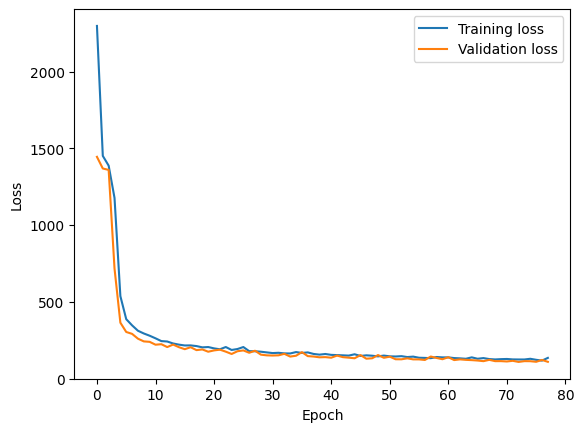

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
### Let's make some more images to test the model
Xtest = []
ytest = []
np.random.seed(43)

df = generate_triangle_data(n_samples=500, angle_mode="random")
for i in range(500):
    a, b, angle = df.iloc[i][["a", "b", "angle_deg"]]
    img = triangle_image_array(a, b, angle)
    # label
    c = df.iloc[i]["c"]
    
    Xtest.append(img)
    ytest.append(c)

Xtest = np.array(Xtest)[..., np.newaxis]  # Shape (5000, 64, 64, 1)
ytest = np.array(ytest)

In [32]:
print(Xtest[:5].shape)
y1_predict = test_model1.predict(Xtest)

(5, 64, 64, 1)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


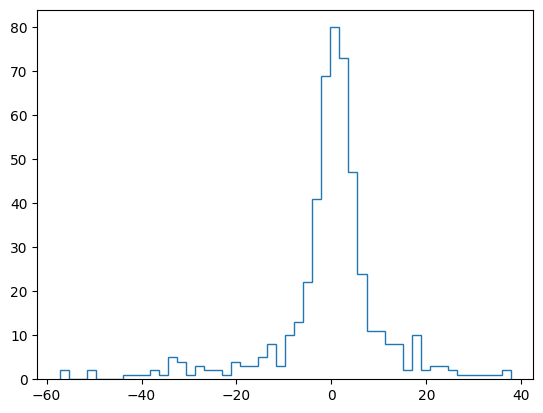

In [38]:
plt.hist(y1_predict.flatten()-ytest, bins=50, histtype='step', label="Residuals");

### Let's try another model

In [39]:
test_model2 = get_model(model_number=2)
test_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,745 (30.25 KB)

 Trainable params: 7,745 (30.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
test_model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error
)
history2 = test_model2.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5642.8511 - mae: 64.7926 - val_loss: 1436.6675 - val_mae: 30.5685
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1446.1321 - mae: 30.7823 - val_loss: 1402.3759 - val_mae: 30.4283
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1453.9313 - mae: 31.1205 - val_loss: 1396.3328 - val_mae: 30.4726
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1433.6854 - mae: 30.8375 - val_loss: 1411.4360 - val_mae: 30.8928
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1429.8673 - mae: 30.6808 - val_loss: 1394.5707 - val_mae: 30.4961
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1463.4097 - mae: 31.2155 - val_loss: 1408.7042 - val_mae: 30.4074
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1444.9330 - mae: 30.7427 - val_loss: 1393.4916 - val_mae: 30.5101
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1464.6754 - mae: 31.0632 - val_loss: 1396.0670 - val_mae: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


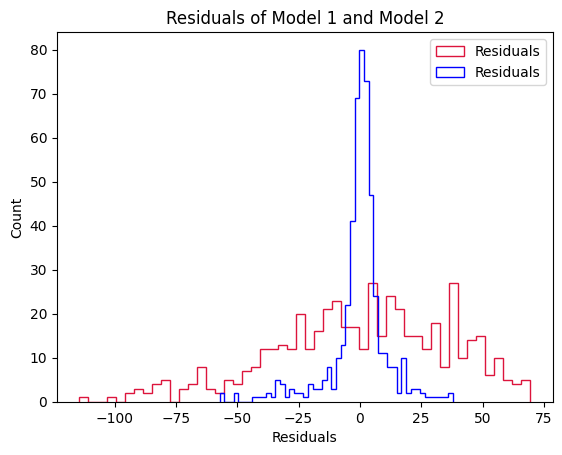

In [42]:
y2_predict = test_model2.predict(Xtest)

plt.hist(y2_predict.flatten()-ytest, bins=50, histtype='step', label="Residuals", color='crimson');
plt.hist(y1_predict.flatten()-ytest, bins=50, histtype='step', label="Residuals", color='blue');
plt.legend()
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residuals of Model 1 and Model 2")
plt.show()

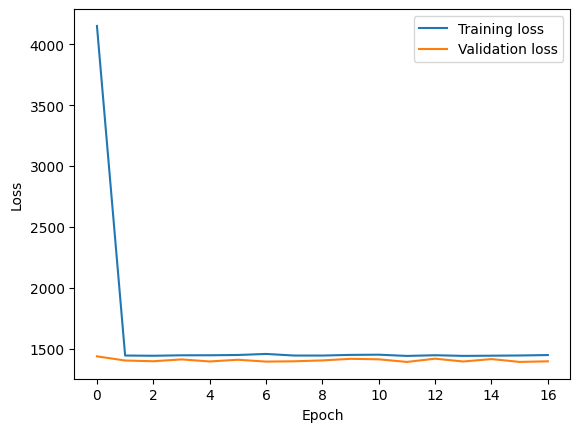

In [43]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clearly the second model is not complex enough to capture details. More models can be explored but for now, we will leave it at this.

Then there are tools around "how to handle the model weights, reuse, retrain" etc. Often fancified as "MLOps".

Honorable mentions on some important layers; <br>
`Regularization`, `Dropouts`, `BatchNorm` <br>
*maybe* we do some examples later.